# Capstone 2

## Part 4: Modelling

Let's try out some new models! First, let's have a look at a linear regression. We'll sort the coefficients by absolute value to get a sense of the linear contribution of each feature to the quality score:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
std_wines = pd.read_csv('../data/std_data.csv')
all_data = pd.concat([train,test])

Xtrain,Xtest,ytrain,ytest = train_test_split(all_data.drop('quality',axis=1),all_data.quality, stratify=all_data.quality)

In [2]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(Xtrain,ytrain)
coefficients = enumerate(model1.coef_)
coefficients = sorted(coefficients, key=lambda x: -abs(x[1]))

print('\nLinear regression intercept:\n',model1.intercept_)


Linear regression intercept:
 6.079689253305768


The regression indicates that a hypothetical wine with zero-valued features gets a quality score of 6.1. Recall that the wine type (red/white) remains as an unscaled binary value where reds have a value of zero. Therefore, this hypothetical wine is red. 

All of the other features were centered and scaled. Therefore, each feature (a z-score) represents the deviation from the average-valued wine (with the average computed on all reds and whites combined).

In [3]:
print("\nLinear regression coefficients sorted by absolute value:\n")
for i, coef in coefficients:
    print(i, '\t', coef, '\t', Xtrain.columns[i])


Linear regression coefficients sorted by absolute value:

11 	 -0.34204135827349946 	 type_white
3 	 -0.3020577055083056 	 density
7 	 0.2995463664319834 	 residual sugar
9 	 0.26757061499015783 	 alcohol
6 	 -0.2526818072606567 	 volatile acidity
2 	 0.11455323090695511 	 fixed acidity
4 	 0.10083777155446796 	 sulphates
1 	 0.08168211995635405 	 pH
8 	 0.07514498101763666 	 free sulfur dioxide
0 	 -0.07295482505246687 	 total sulfur dioxide
5 	 -0.020066843425552264 	 chlorides
10 	 -0.015631272360560073 	 citric acid


The coefficient multiplying by the wine type is negative. Apparently red wines are preferred over whites with the quality score dropping by -0.37 simply because it's white. 

This list indicates a rough preference for:

1. Red wine
2. Lower density
3. Higher residual sugar
4. Lower volatile acidity
5. Higher alcohol

## Multicollinearity

In the wine making process, the density falls as higher-density sugar is consumed and replaced by lower-density alcohol. These three features should be correlated to some degree and perhaps colinear. If this is the case, we may find that there's instability in these coefficients as the model is retrained using different training samples. Let's have a look at coefficient stability.

Here we'll train the regression on different subsamples of the data, saving the intercept and coefficient each time. This will enable us to build histograms of the coefficients and estimate their variance.

In [4]:
from sklearn.model_selection import train_test_split

column_names = ['intercept']
column_names.extend(Xtrain.columns)
coefficients = pd.DataFrame(columns = column_names)

model = LinearRegression()
param_list = []

for i in range(1000):
    X, _, y, _ = train_test_split(std_wines.drop('quality',axis=1), std_wines['quality'], train_size=0.8, random_state=i)
    model.fit(X,y)
    parameters = list(model.coef_)
    parameters.insert(0,model.intercept_)
    param_list.append(parameters)

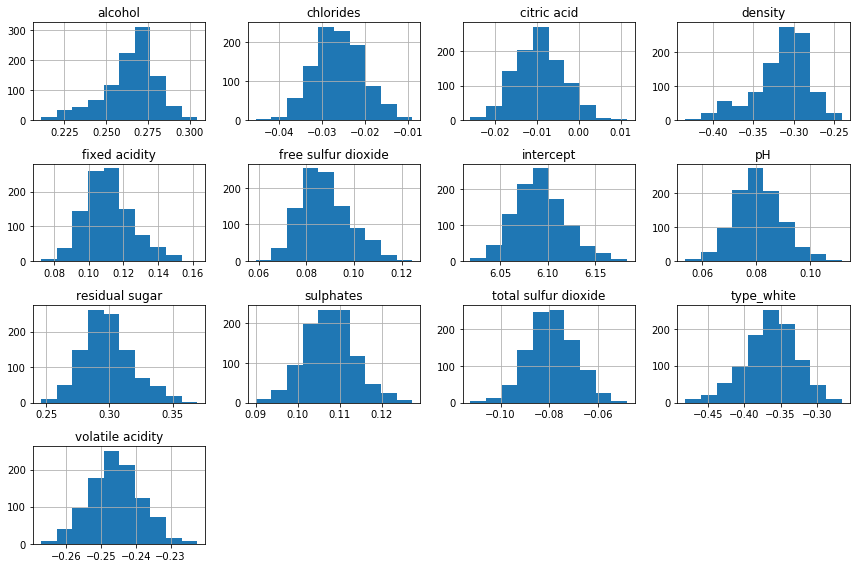

In [5]:
import matplotlib.pyplot as plt

model_parameters = pd.DataFrame(param_list,columns = column_names)
model_parameters.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


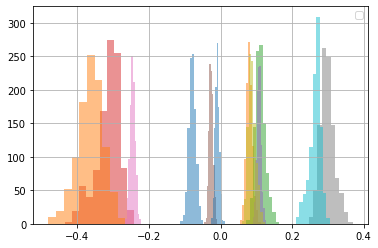

In [6]:
# Let's put the coefficients into perspective by plotting them together
import numpy as np

fig, ax = plt.subplots()
column_names = model_parameters.columns

for column in column_names:
    if column == 'intercept':
        continue
        
    model_parameters[column].hist(alpha=0.5)
    # column_heights, column_bins = np.histogram(model_parameters[column],bins=20)
    # ax.bar(column_bins[:-1],column_heights,label=column)

ax.legend()
fig.show()

The coefficients and intercept seem reasonably behaved. The shape of the density histogram doesn't look as much like a Gaussian distribution as the others. Is this a sign of mild multicollinearity? 

## Baseline performance
How does a simple linear regression perform in predicting wine quality?

Here's a plot of the model predictions on the test set. Jitter is added to the quality score to spread out the points horizontally.

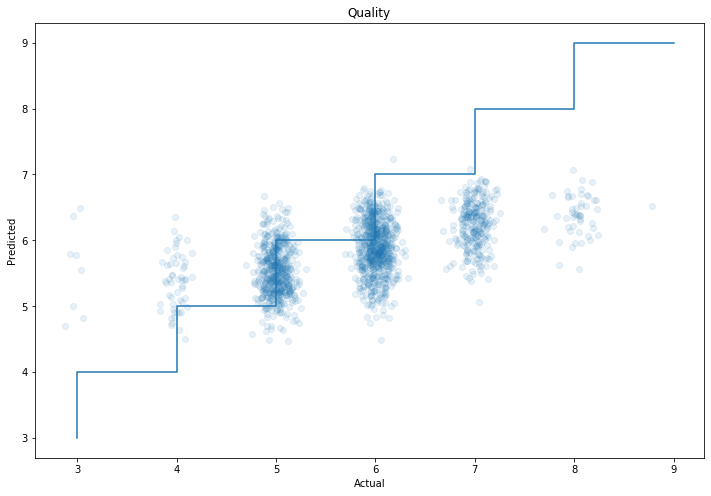

In [30]:
import numpy as np

y_pred = model1.predict(Xtest)

def class_scatter(test,pred):
    plt.figure(figsize=(12,8))
    plt.scatter(test + np.random.normal(size=len(ytest))/10,pred,alpha = 0.1)
    plt.step(range(3,10),range(3,10))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Quality')
    plt.show()
    
class_scatter(ytest,y_pred)

The performance doesn't look so good. This looks like a the simple model is underfitting significantly. There's significant bias. Wines with an actual quality score of 6 seem to have the lowest bias the predictions seem almost centered around 6. We'll need some other approach to perform better than this.

Let's see how some of the other metrics look.

In [8]:
from sklearn.metrics import explained_variance_score, mean_squared_error

print("Explained Variance:\n", explained_variance_score(ytest,y_pred))
print("Mean Squared Error:\n",mean_squared_error(ytest,y_pred))

Explained Variance:
 0.318341560525517
Mean Squared Error:
 0.520076139670302


## Decision Tree
Let's have a look at a decision tree.
### Decision Tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss

tree = DecisionTreeClassifier(min_samples_split = 50)
tree.fit(Xtrain,ytrain)
y_pred = tree.predict(Xtest)
print(tree.classes_)
log_loss(ytest,tree.predict_proba(Xtest))

[3 4 5 6 7 8 9]


3.1101927703030086

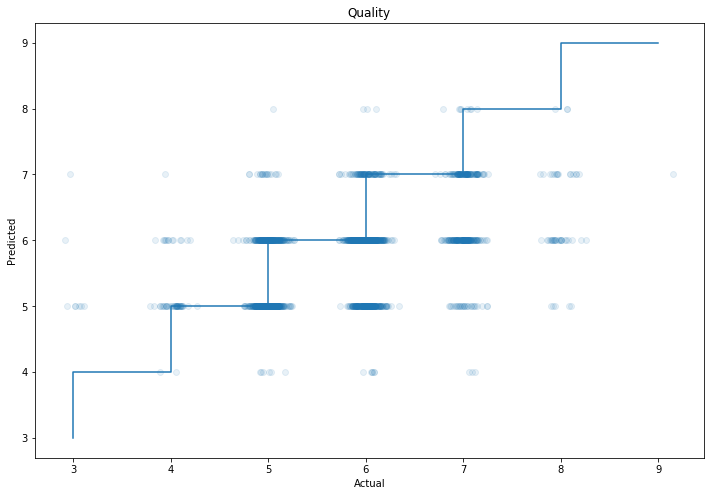

In [33]:
class_scatter(ytest,y_pred)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.12      0.04      0.06        54
           5       0.56      0.61      0.58       535
           6       0.55      0.61      0.58       709
           7       0.45      0.36      0.40       270
           8       0.20      0.06      0.10        48
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1625
   macro avg       0.27      0.24      0.24      1625
weighted avg       0.51      0.53      0.51      1625



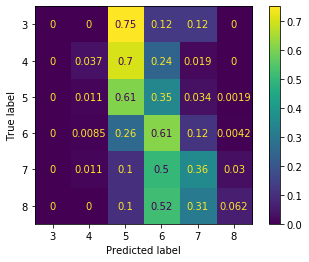

In [34]:
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(ytest,y_pred))
plot_confusion_matrix(tree,Xtest,ytest,labels=[3,4,5,6,7,8],normalize='true')
plt.show()

In [35]:
print(max(ytest),min(ytest),max(y_pred),min(y_pred))

9 3 8 4


In [36]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor( min_samples_split = 50)
tree.fit(Xtrain,ytrain)
y_pred = tree.predict(Xtest)

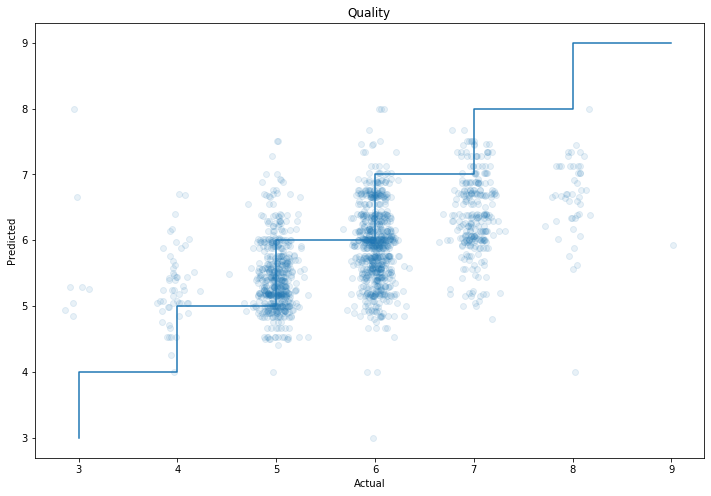

In [37]:
class_scatter(ytest,y_pred)

The results look horrible! The decision tree classifier is only putting out 3 different labels, ignoring 3 others entirely. The regressor is finding all kinds of non-integer immediate values. So it looks like the integer score classification task is not a trivial problem. 

Let's try a random forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier()
randomForest.fit(Xtrain,ytrain)
y_pred = randomForest.predict(Xtest)
log_loss(ytest,randomForest.predict_proba(Xtest))

0.9373310908928517

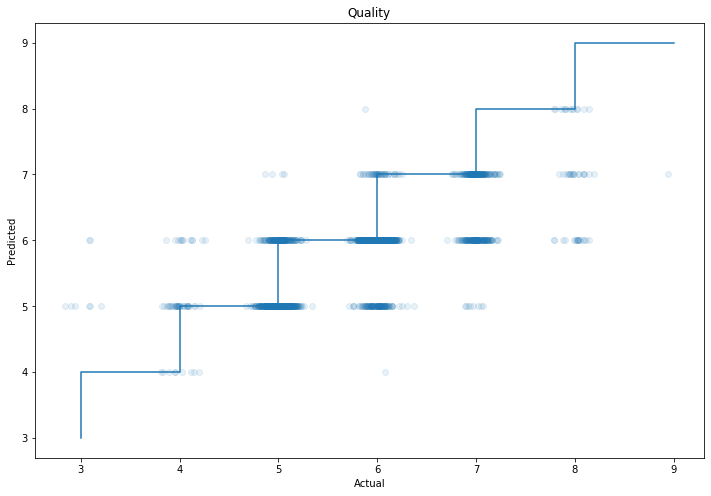

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.90      0.17      0.28        54
           5       0.72      0.73      0.72       535
           6       0.65      0.79      0.71       709
           7       0.67      0.50      0.57       270
           8       0.93      0.27      0.42        48
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1625
   macro avg       0.55      0.35      0.39      1625
weighted avg       0.69      0.68      0.67      1625



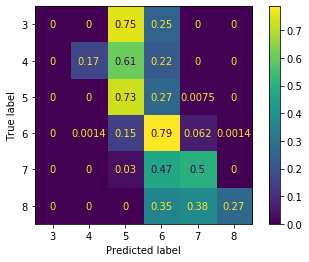

In [39]:
class_scatter(ytest,y_pred)
print(classification_report(ytest,y_pred))
plot_confusion_matrix(randomForest,Xtest,ytest,labels=[3,4,5,6,7,8],normalize='true')
plt.show()

The results look a litte better. We're still missing predictions as low as 3. Let's see if densifying the forest will help.

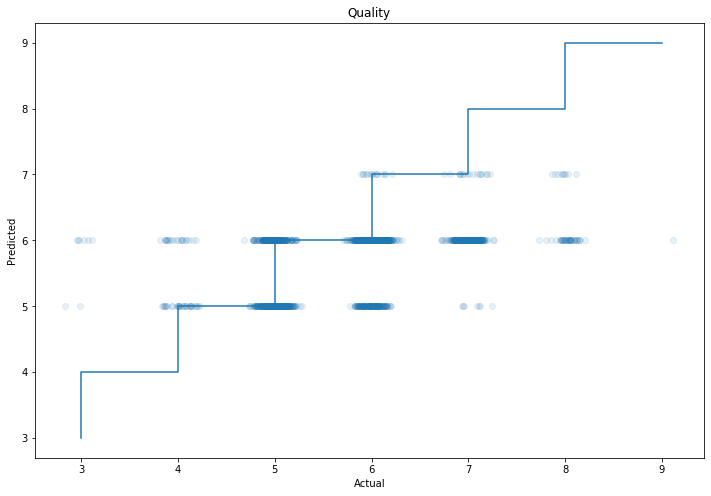

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        54
           5       0.64      0.59      0.61       535
           6       0.51      0.78      0.62       709
           7       0.41      0.06      0.11       270
           8       0.00      0.00      0.00        48
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1625
   macro avg       0.22      0.21      0.19      1625
weighted avg       0.50      0.55      0.49      1625



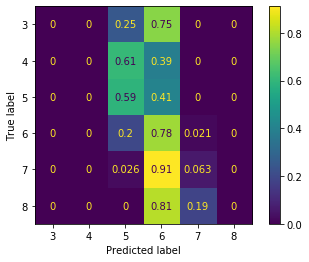

In [40]:
randomForest = RandomForestClassifier(n_estimators=1000,max_depth=4)
randomForest.fit(Xtrain,ytrain)
y_pred = randomForest.predict(Xtest)
class_scatter(ytest,y_pred)
print(classification_report(ytest,y_pred))
plot_confusion_matrix(randomForest,Xtest,ytest,labels=[3,4,5,6,7,8],normalize='true')
plt.show()

It looks like more of the same. There's the general linear trend that tends to be not as steep as it should be. We need more variance. Random forest relies on Bootstrapping and reduces variance. This is the opposite of what I want. 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.01      0.25      0.01         8
           4       0.00      0.00      0.00        54
           5       0.46      0.36      0.40       535
           6       0.50      0.54      0.52       709
           7       0.42      0.06      0.11       270
           8       0.05      0.02      0.03        48
           9       0.00      0.00      0.00         1

    accuracy                           0.37      1625
   macro avg       0.21      0.18      0.15      1625
weighted avg       0.44      0.37      0.38      1625



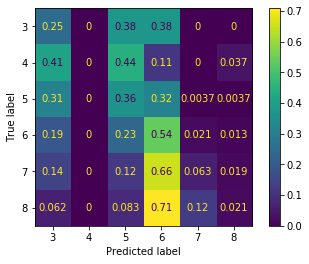

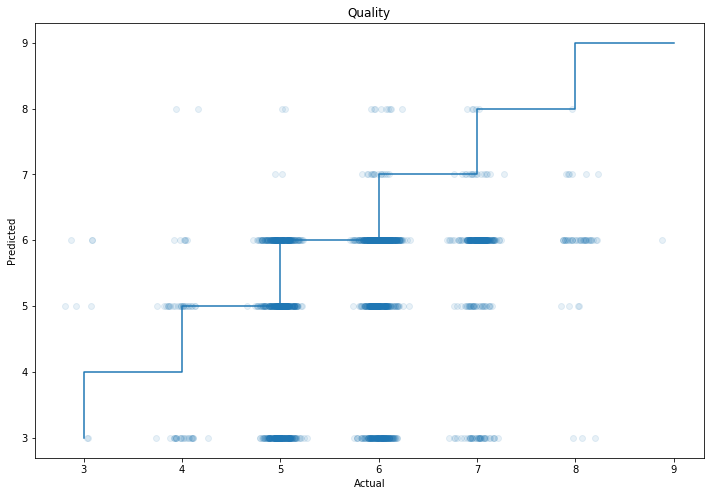

In [42]:
from sklearn.ensemble import AdaBoostClassifier

AdaModel = AdaBoostClassifier(learning_rate=1,n_estimators=100)

def check_out_model(model):
    model.fit(Xtrain,ytrain)
    y_pred = model.predict(Xtest)
    print(classification_report(ytest,y_pred))
    plot_confusion_matrix(model,Xtest,ytest,labels=[3,4,5,6,7,8],normalize='true')
    plt.show()
    class_scatter(ytest,y_pred)
    
check_out_model(AdaModel)

AdaBoost is on the scoreboard! Finally, we've got a significant number of 3's predicted. 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.69      0.17      0.27        54
           5       0.73      0.74      0.73       535
           6       0.65      0.80      0.72       709
           7       0.68      0.47      0.56       270
           8       0.82      0.29      0.43        48
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1625
   macro avg       0.51      0.35      0.39      1625
weighted avg       0.69      0.68      0.67      1625



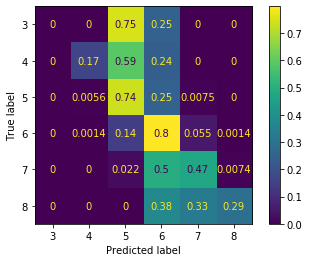

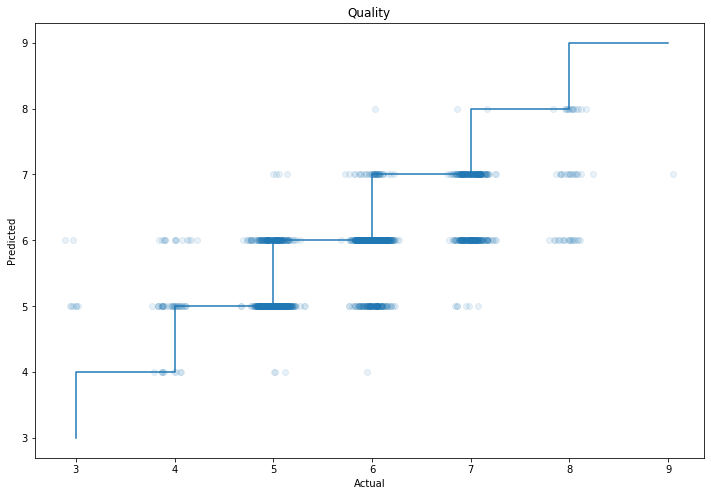

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
check_out_model(ExtraTreesClassifier())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.83      0.19      0.30        54
           5       0.74      0.73      0.73       535
           6       0.65      0.80      0.72       709
           7       0.68      0.49      0.57       270
           8       0.82      0.29      0.43        48
           9       0.00      0.00      0.00         1

    accuracy                           0.69      1625
   macro avg       0.53      0.36      0.39      1625
weighted avg       0.69      0.69      0.67      1625



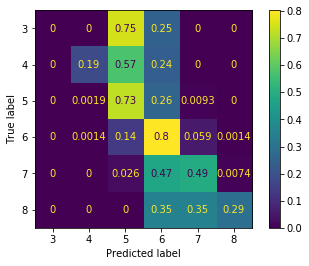

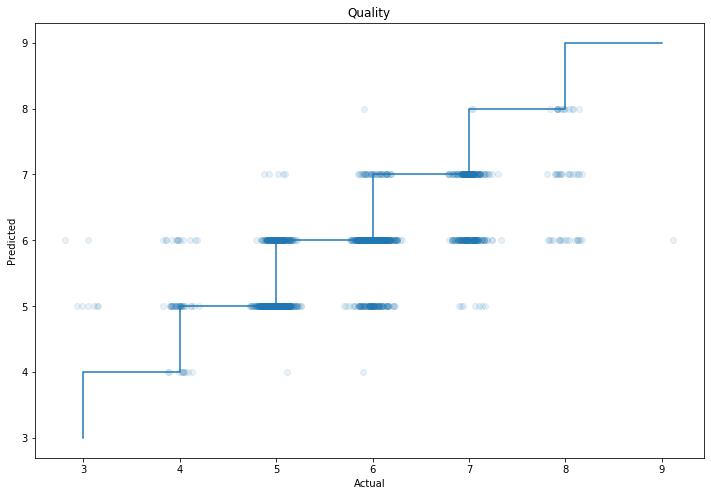

In [44]:
check_out_model(ExtraTreesClassifier(criterion='entropy',n_estimators=200))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.11      0.12      0.12         8
           4       0.24      0.19      0.21        54
           5       0.64      0.65      0.65       535
           6       0.62      0.64      0.63       709
           7       0.53      0.50      0.51       270
           8       0.35      0.35      0.35        48
           9       0.00      0.00      0.00         1

    accuracy                           0.59      1625
   macro avg       0.36      0.35      0.35      1625
weighted avg       0.59      0.59      0.59      1625



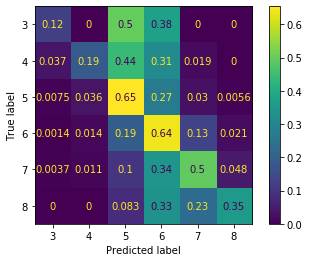

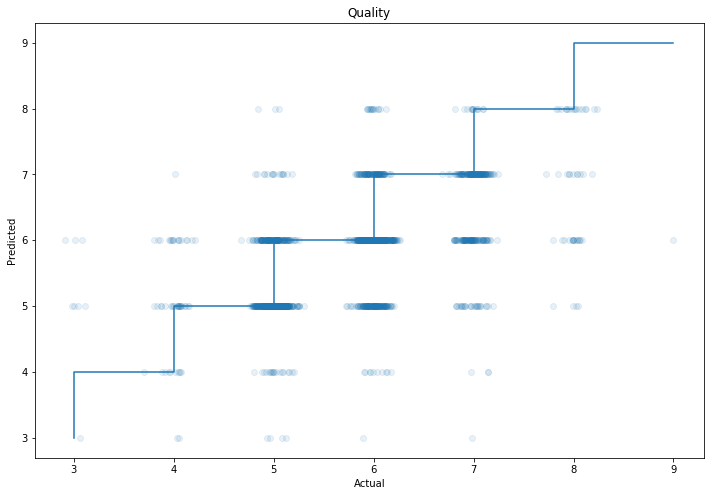

In [45]:
check_out_model(DecisionTreeClassifier())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        54
           5       0.64      0.60      0.62       535
           6       0.52      0.77      0.62       709
           7       0.45      0.11      0.18       270
           8       0.00      0.00      0.00        48
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1625
   macro avg       0.23      0.21      0.20      1625
weighted avg       0.51      0.55      0.50      1625



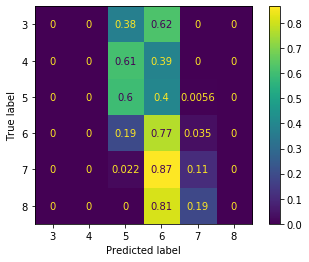

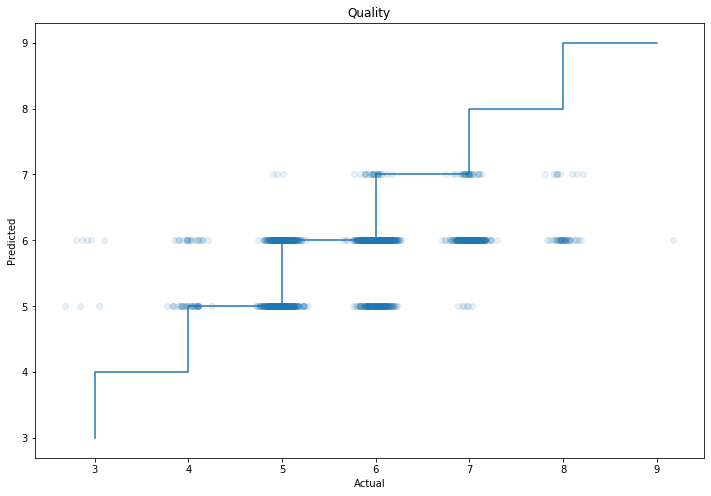

In [46]:
check_out_model(RandomForestClassifier(max_depth=5,n_estimators=1000))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        54
           5       0.60      0.61      0.61       535
           6       0.51      0.77      0.62       709
           7       0.50      0.03      0.06       270
           8       0.00      0.00      0.00        48
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1625
   macro avg       0.23      0.20      0.18      1625
weighted avg       0.51      0.54      0.48      1625



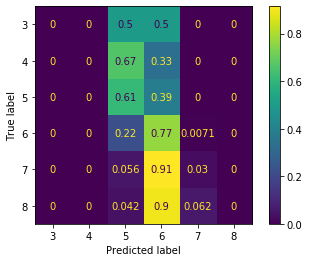

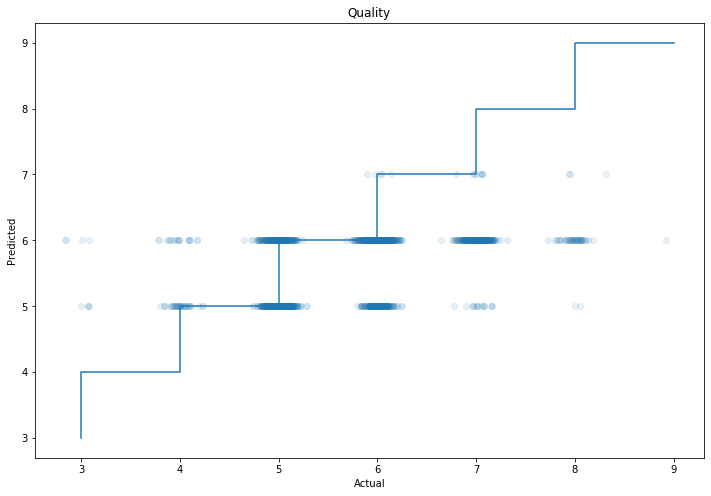

In [47]:
from sklearn.svm import LinearSVC

check_out_model(LinearSVC())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.33      0.02      0.04        54
           5       0.57      0.60      0.58       535
           6       0.53      0.64      0.58       709
           7       0.46      0.34      0.39       270
           8       0.00      0.00      0.00        48
           9       0.00      0.00      0.00         1

    accuracy                           0.53      1625
   macro avg       0.27      0.23      0.23      1625
weighted avg       0.51      0.53      0.51      1625



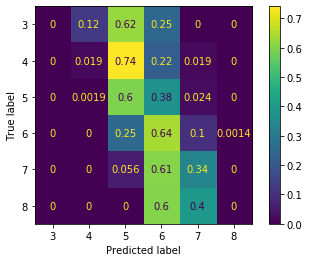

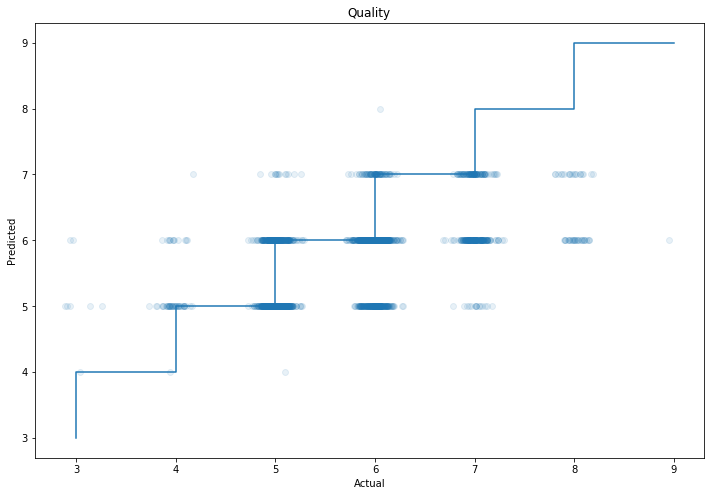

In [48]:
from sklearn.neighbors import KNeighborsClassifier

check_out_model(KNeighborsClassifier(n_neighbors=20))

              precision    recall  f1-score   support

           3       0.38      0.38      0.38         8
           4       0.09      0.07      0.08        54
           5       0.54      0.53      0.53       535
           6       0.47      0.34      0.39       709
           7       0.20      0.12      0.15       270
           8       0.33      0.06      0.11        48
           9       0.00      1.00      0.01         1

    accuracy                           0.35      1625
   macro avg       0.29      0.36      0.23      1625
weighted avg       0.43      0.35      0.38      1625



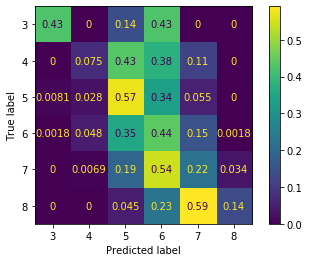

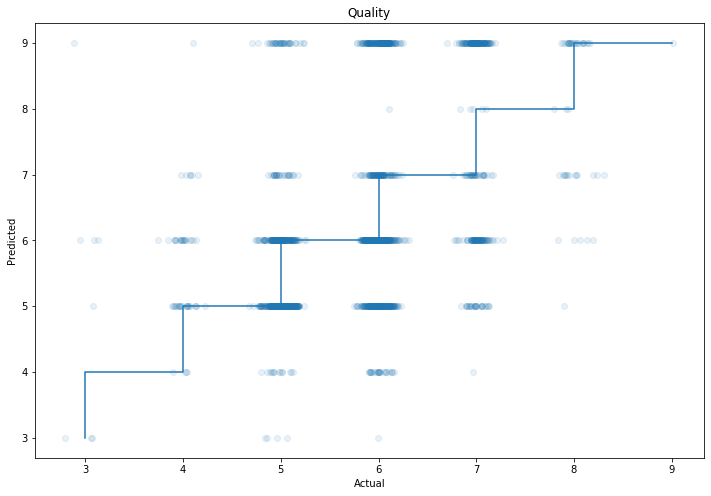

In [49]:
from sklearn.naive_bayes import GaussianNB

check_out_model(GaussianNB())

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.17      0.04      0.06        54
           5       0.66      0.60      0.63       535
           6       0.57      0.74      0.64       709
           7       0.56      0.35      0.43       270
           8       0.44      0.17      0.24        48
           9       0.00      0.00      0.00         1

    accuracy                           0.59      1625
   macro avg       0.34      0.27      0.29      1625
weighted avg       0.58      0.59      0.57      1625



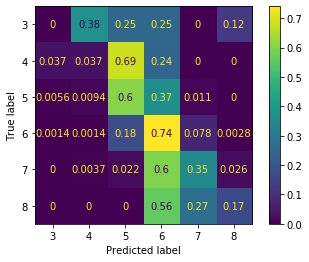

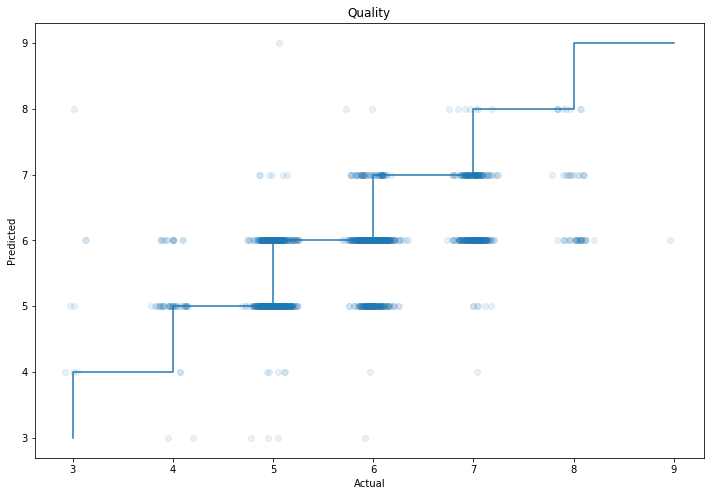

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

check_out_model(GradientBoostingClassifier())

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        54
           5       0.62      0.57      0.60       535
           6       0.52      0.68      0.59       709
           7       0.46      0.33      0.39       270
           8       0.17      0.04      0.07        48
           9       0.00      0.00      0.00         1

    accuracy                           0.54      1625
   macro avg       0.25      0.23      0.23      1625
weighted avg       0.51      0.54      0.52      1625



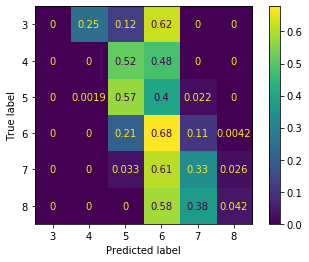

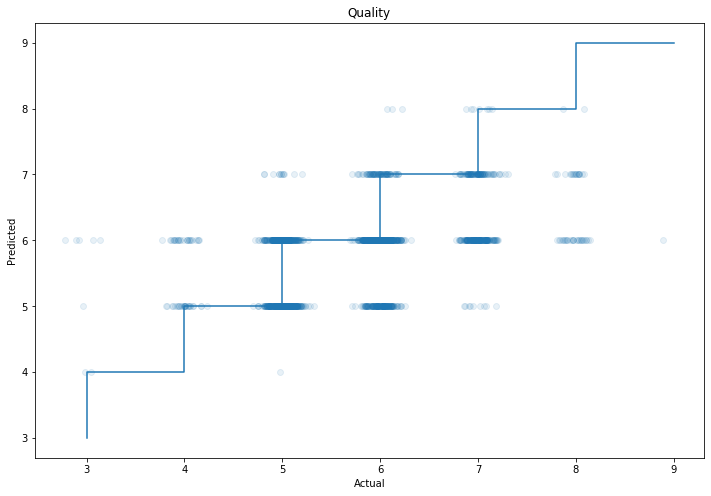

In [51]:
check_out_model(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                           max_depth=2, random_state=0))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         8
           4       0.57      0.07      0.13        54
           5       0.63      0.60      0.61       535
           6       0.55      0.68      0.61       709
           7       0.47      0.39      0.43       270
           8       0.00      0.00      0.00        48
           9       0.00      0.00      0.00         1

    accuracy                           0.56      1625
   macro avg       0.32      0.25      0.25      1625
weighted avg       0.54      0.56      0.54      1625



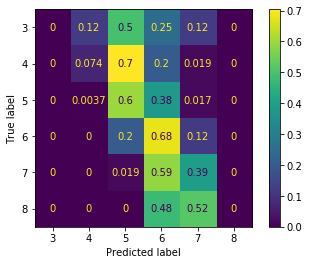

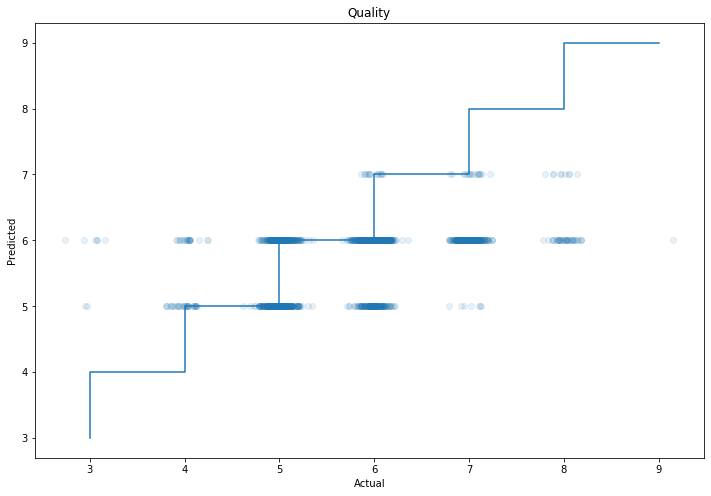

In [28]:
from sklearn.neural_network import MLPClassifier

check_out_model(MLPClassifier((10,2),learning_rate='adaptive',learning_rate_init=0.01,random_state=0))

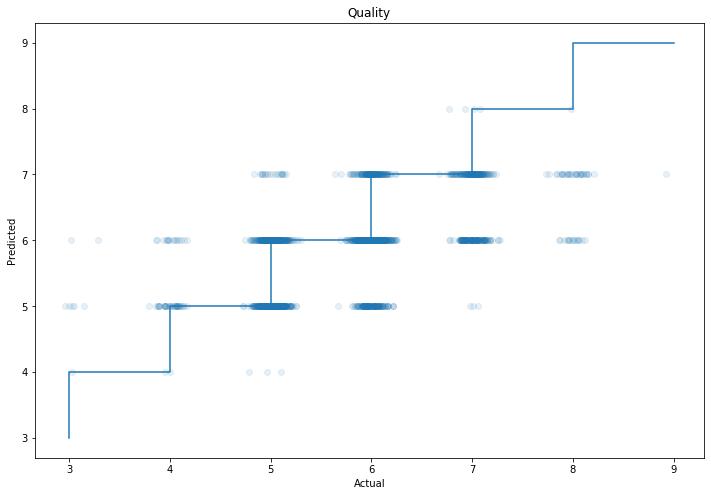

In [29]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor((10,10),learning_rate='adaptive',learning_rate_init=0.01,random_state=0)
model.fit(Xtrain,ytrain)
y_pred = np.round(model.predict(Xtest),0)

class_scatter()

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

rf = RandomForestClassifier(criterion='entropy',n_jobs=-1,)
params = {'max_depth':[1,2,3,None],'n_estimators':[100,200,300,400,500],'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1)}
rscv = RandomizedSearchCV(rf,params,n_iter=100,cv=4,random_state=0)
rscv.fit(Xtrain,ytrain)

RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [61]:
rscv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None,
                       max_features=0.26854511740701914, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [86]:
y_pred = rscv.predict(Xtest)

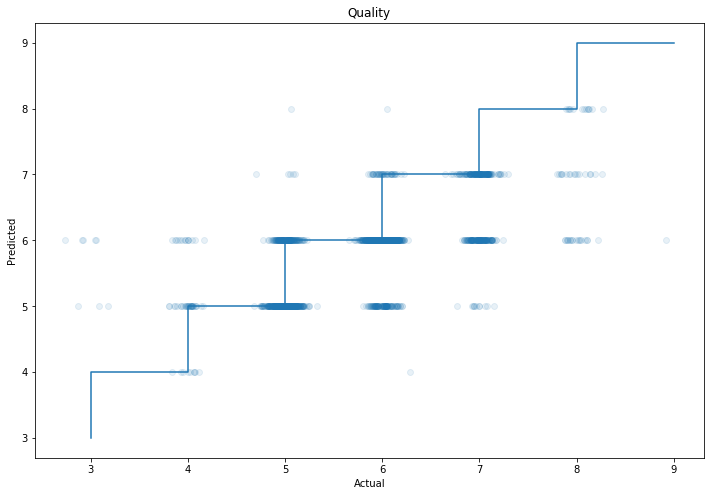

In [87]:
class_scatter(ytest,y_pred)

In [102]:
y_probabilities = rscv.predict_proba(Xtest)
table = pd.DataFrame(y_probabilities,columns = [3,4,5,6,7,8,9])
table.reset_index()
table['ytest'] = ytest
table['y_pred'] = y_pred
table[table['ytest'] == 8]

,3,4,5,6,7,8,9,ytest,y_pred
5,0.000,0.005,0.065,0.420,0.480,0.030,0.000,8,7
90,0.000,0.005,0.080,0.325,0.565,0.025,0.000,8,7
115,0.000,0.005,0.065,0.455,0.375,0.100,0.000,8,6
127,0.005,0.005,0.005,0.170,0.165,0.650,0.000,8,8
129,0.000,0.000,0.020,0.105,0.150,0.725,0.000,8,8
134,0.005,0.005,0.050,0.220,0.075,0.645,0.000,8,8
143,0.000,0.015,0.025,0.470,0.445,0.045,0.000,8,6
147,0.015,0.000,0.000,0.135,0.415,0.405,0.030,8,7
153,0.000,0.015,0.025,0.260,0.550,0.140,0.010,8,7
164,0.000,0.000,0.050,0.630,0.285,0.035,0.000,8,6


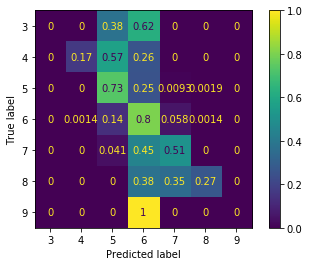

In [105]:
plot_confusion_matrix(rscv,Xtest,ytest,labels=[3,4,5,6,7,8,9],normalize='true')

              precision    recall  f1-score   support

           3       0.38      0.38      0.38         8
           4       0.09      0.07      0.08        54
           5       0.54      0.53      0.53       535
           6       0.47      0.34      0.39       709
           7       0.20      0.12      0.15       270
           8       0.33      0.06      0.11        48
           9       0.00      1.00      0.01         1

    accuracy                           0.35      1625
   macro avg       0.29      0.36      0.23      1625
weighted avg       0.43      0.35      0.38      1625



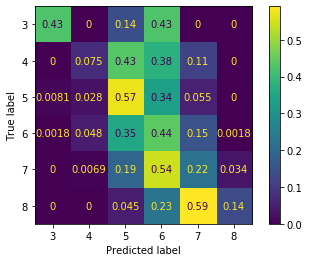

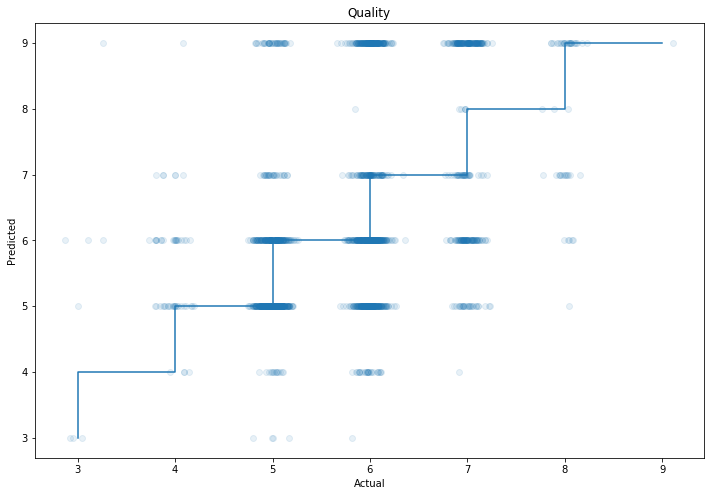

In [106]:
check_out_model(GaussianNB())